# Create & Access a Data Cube via EDC Mass Processing Service

## Imports

In [1]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

# util
import numpy as np
import xarray as xr
import boto3
import json
import csv
import io
from IPython.display import clear_output

# date & time
import time
from datetime import timezone, date, datetime
from dateutil.relativedelta import relativedelta as rdelta
from dateutil.rrule import rrule, MONTHLY

# Oauth
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

## Get authorization token

In [2]:
# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

## Configure Request
Enter start and end date, input bands, indices. The resulting data cube will have two time intervals per month, being split at `day_of_new_interval`.

In [3]:
startdate = date(2018,7,1) # Y,M,D
enddate = date(2018,9,15)  # Y,M,D

input_bands = ["B03",
               "B04",
               "B05",
               "B08"]
indices = ['NDVI',
           "NDWI",
           "CVI"]

bucket_name = "<add bucket name here>"

day_of_new_interval = 16 # leave this unchanged in most of the cases

### Calculate Data Cube Parameters

In [4]:
starttime = datetime(*startdate.timetuple()[:6])
endtime = datetime(*enddate.timetuple()[:6])

d=day_of_new_interval
dates = list(rrule(MONTHLY, dtstart=startdate, until=enddate, bymonthday=[1,d-1,d,31]))
dates = [starttime] + dates if dates[0] != starttime else dates
dates = dates + [endtime] if dates[-1] != endtime else dates

starts = dates[0::2]
starts = [int(d.timestamp()) for d in starts] # timestamps for arithmetic
ends   = [d+rdelta(hour=23, minute=59, second=59) for d in dates[1::2]]
ends   = [int(d.timestamp()) for d in ends]   # timestamps for arithmetic
avg_times = list(np.mean(list(zip(starts,ends)), axis=1))
avg_times = [datetime.utcfromtimestamp(a) for a in avg_times]
avg_times = [dt.isoformat() for dt in avg_times]

In [5]:
masks = ["SCL", "dataMask"] # SCL ... Scene Classification Layer

output_bands = input_bands + indices
output_array =  [ { 'id': "\"" + ob + "\"", 'bands': len(avg_times), "sampleType": "SampleType.UINT16"} for ob in output_bands ]
for oa in output_array:
    if oa["id"] == '"CVI"':
        oa["sampleType"] = "SampleType.FLOAT32"
output_array = str(output_array).replace("'", '')

int_bands = '{' + ','.join([f'{ib}: []' for ib in input_bands]) + '}'
results_object = '{' + ','.join([f'{ob}: []' for ob in output_bands]) + '}'
debug_results = '{' + ','.join([f"{output_bands[i]}: [{i+1}]" for i in range(len(output_bands))]) + '}'
responses = [{"identifier": ob,"format": {"type": "image/tiff"}} for ob in output_bands]

### Define Evalscript & the Request Payload

In [6]:
#double curly brackets render as single curly brackets in f-strings
evalscript = f"""
//VERSION=3

var debug = []

var ic = {{  // index components
  'NDVI':  ["B08", "B04"],
  "GNDVI": ["B08", "B03"],
  "BNDVI": ["B08", "B02"],
  "NDSI":  ["B11", "B12"],
  "NDWI":  ["B03", "B08"]
}}

function setup(ds) {{
  return {{
    input: [{{
      bands: {str(input_bands + masks)}, 
      units: "DN"
    }}],
    output: {output_array},
    mosaicking: Mosaicking.ORBIT       
  }}
}}

function validate (sample) {{
  if (sample.dataMask!=1) return false;
  
  var scl = Math.round(sample.SCL);
  
  if (scl === 3) {{ // SC_CLOUD_SHADOW
    return false;
  }} else if (scl === 9) {{ // SC_CLOUD_HIGH_PROBA
    return false; 
  }} else if (scl === 8) {{ // SC_CLOUD_MEDIUM_PROBA
    return false;
  }} else if (scl === 7) {{ // SC_CLOUD_LOW_PROBA
    //return false;
  }} else if (scl === 10) {{ // SC_THIN_CIRRUS
    return false;
  }} else if (scl === 11) {{ // SC_SNOW_ICE
    return false;
  }} else if (scl === 1) {{ // SC_SATURATED_DEFECTIVE
    return false;
  }} else if (scl === 2) {{ // SC_DARK_FEATURE_SHADOW
    //return false;
  }}
  return true;
}}

function calculateIndex(a,b)
{{
  if ((a+b)==0) return 0;
  // stretch [-1,+1] to [0,1]
  return ((a-b)/(a+b)+1)/2;
}}

function interpolatedValue(arr)
{{
  //here we define the function on how to define the proper value - e.g. linear interpolation; we will use average 
  if (arr.length==0) return 0;
  if (arr.length==1) return arr[0];
  var sum = 0;
  for (j=0;j<arr.length;j++)
  {{sum+=arr[j];}}
  return Math.round(sum/arr.length);
}}

var results = {results_object}

// We split each month into two halves. This will make it easier to append months to data cube later
var day_of_new_interval = {day_of_new_interval}
var endtime = new Date({datetime(*enddate.timetuple()[:3],23,59,59).timestamp()*1000}) // UNIX epoch in ms

function evaluatePixel(samples, scenes, inputMetadata, customData, outputMetadata) {{
  
  //Debug part returning "something" if there are no  valid samples (no observations)
  if (!samples.length)
  return {debug_results}
  
  var is_in_last_half_of_month = endtime.getUTCDate() >= day_of_new_interval
  var i = 0; // interval number
  var int_bands = {int_bands}
  
  for (var j = 0; j < samples.length; j++) {{
    
    //TODO order should be reversed when we go leastRecent
    
    // if scene is outside of current half of month, fill result array and change half of month
    // algorithm starts with most recent observation
    if (( !is_in_last_half_of_month && scenes[j].date.getUTCDate() >= day_of_new_interval) ||
    (  is_in_last_half_of_month && scenes[j].date.getUTCDate() <  day_of_new_interval))
    {{
      fillResultArray(i, int_bands)
      
      //reset values
      for (var int_b in int_bands) {{
        int_bands[int_b] = []
      }}
      
      is_in_last_half_of_month = !is_in_last_half_of_month;
      i++;
    }}
    
    if (validate(samples[j]))
    {{
      // push input samples into their respective arrays
      for (var int_b in int_bands) {{
        int_bands[int_b].push(samples[j][int_b])
      }}
    }}
    
  }}
  
  //execute this for the last interval 
  fillResultArray(i, int_bands);
  
  return results
}}

function fillResultArray(i, int_bands)
{{
  for (var b in int_bands) {{
    if(int_bands[b].length==0) results[b][i] = 0
    else results[b][i] = interpolatedValue(int_bands[b])
  }}
  
  for (var ix of {indices}) {{
    if(ic.hasOwnProperty(ix)) {{
      results[ix][i] = 65535*calculateIndex(
        results[ic[ix][0]][i],
        results[ic[ix][1]][i]
      )
    }}
    if(ix==="CVI"){{
      // output sample type for CVI is FLOAT32
      results[ix][i] = results["B08"][i]*results["B05"][i] / (results["B03"][i]*results["B03"][i])
    }}
  }}
}}

function updateOutputMetadata(scenes, inputMetadata, outputMetadata) {{
  outputMetadata.userData = {{
    "date_created": Date(),
    "metadata": scenes.map(s => {{
      s.date = s.date.toString()
      return s
    }}),
    "time" : {avg_times},
    "debug": debug
  }}
}}
"""

In [7]:
payload = {
  "processRequest": {
    "input": {
      "bounds": {
        "properties": {
          "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
        },
        "bbox": [16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863]
      },
      "data": [
        {
          "location": "AWS:eu-central-1",
          "type": "S2L2A",
          "dataFilter": {
            "timeRange": {
              "from": starttime.isoformat() + 'Z',
              "to": endtime.isoformat() + 'Z'
            },
            "mosaickingOrder": "mostRecent",
            "maxCloudCoverage": 100,
            "previewMode": "DETAIL"
          }
        }
      ]
    },
    "output": {
      "responses": [*responses]
    },
    "evalscript": evalscript
  },
  "tilingGridId": 0,
  "bucketName": bucket_name,
  "resolution": 60.0,
  "description": "Test Loipersbach"
}

headers = {
  #'Accept': 'application/tar'
}

## Send Request and Create Data Cube

In [8]:
def generate_url(request_id="", action=""):
    url = 'https://services.sentinel-hub.com/batch/v1/process/'
    if request_id:
        url += f'{request_id}/'
        if action:
            url += f'{action}'
    return url

In [9]:
%%time
# Creating request
response = oauth.request("POST", generate_url(), headers=headers, json = payload).json()
request_id = response["id"]

# Starting processing
oauth.request("POST", generate_url(request_id, 'start'))

# Polling for completion
response_status = ""
while response_status not in ['DONE', 'FAILED']:
    clear_output(True); print('Waiting upon completion...');
    response_status = oauth.request("GET", generate_url(request_id)).json()['status']
    print(f"Request {request_id} {response_status}")
    time.sleep(1)

Waiting upon completion...
Request aec584eb-0c2b-41ea-979c-36d77fcfb7f5 DONE
CPU times: user 1.24 s, sys: 126 ms, total: 1.37 s
Wall time: 3min 7s


In [10]:
tiles = oauth.request('GET', generate_url(request_id, 'tiles')).json()['member']
costs = sum([t['cost'] for t in tiles])
print(f'Processing Costs: {costs:.2f} Processing Units')

Processing Costs: 21.28 Processing Units


In [11]:
s3 = boto3.resource('s3')
bk = s3.Bucket(bucket_name)
print("Data Cube Size: {:.2f} MiB"
      .format(sum([obj.size for obj in bk.objects.all().filter(Prefix=request_id)])/2**20)) # total size in bytes

Data Cube Size: 5.90 MiB


In [12]:
%%capture
# Save metadata to bucket
bk.put_object(Key=request_id + '/userdata.json', Body=json.dumps({
    'bands': output_bands,
    'request_id': request_id,
    'tiles': [tile['id'] for tile in tiles],
    'time': avg_times    
}))

## Access Data Cube

In [13]:
# Load metadata
userdata_obj = bk.Object(f'{request_id}/userdata.json')
file_stream = io.BytesIO()
userdata_obj.download_fileobj(file_stream) # load userdata.json into file_stream
userdata = json.loads(file_stream.getvalue())
userdata

{'bands': ['B03', 'B04', 'B05', 'B08', 'NDVI', 'NDWI', 'CVI'],
 'request_id': 'aec584eb-0c2b-41ea-979c-36d77fcfb7f5',
 'tiles': [9166],
 'time': ['2018-07-08T11:59:59.500000',
  '2018-07-23T23:59:59.500000',
  '2018-08-08T11:59:59.500000',
  '2018-08-23T23:59:59.500000',
  '2018-09-08T11:59:59.500000']}

In [14]:
# Load data cube into xarray Dataset
dss = []
for t in userdata['tiles']:
    arrs = {b: xr.open_rasterio(f's3://{bucket_name}/{request_id}/{t}/{b}.tif') for b in userdata['bands']}
    dss.append(xr.Dataset(arrs))
ds = xr.combine_by_coords(dss)

# Describe xarray Dataset with metadata
ds = ds.rename({'band': 'time', 'y': 'lat', 'x': 'lon'})
ds.coords['time'] = [np.datetime64(t) for t in userdata['time']]
ds

<xarray.Dataset>
Dimensions:  (lat: 334, lon: 334, time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2018-07-08T11:59:59.500000 ... 2018-09-08T11:59:59.500000
  * lat      (lat) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.28e+06 5.28e+06
  * lon      (lon) float64 6e+05 6.001e+05 6.002e+05 ... 6.2e+05 6.2e+05
Data variables:
    B03      (time, lat, lon) uint16 ...
    B04      (time, lat, lon) uint16 ...
    B05      (time, lat, lon) uint16 ...
    B08      (time, lat, lon) uint16 ...
    NDVI     (time, lat, lon) uint16 ...
    NDWI     (time, lat, lon) uint16 ...
    CVI      (time, lat, lon) float32 ...

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


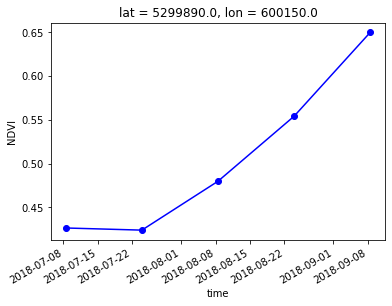

In [15]:
def scale_index(val, src=(0,2**16-1), dst=(-1,+1)): 
    """
    Scale the given value from the scale of src to the scale of dst.
    """
    return ((val - src[0]) / (src[1]-src[0])) * (dst[1]-dst[0]) + dst[0]

scale_index(ds.isel(lat=2, lon=2).NDVI).plot.line('b-o')